In [2]:
!pip install xgboost

In [1]:
!pip uninstall scikit-learn
!pip install scikit-learn==1.2.2

^C


In [106]:
import numpy as np
import pandas as pd
import datetime
import time
from sklearn.model_selection import train_test_split


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Metrics to use other than the accuracy (Success rate)
# https://scikit-learn.org/stable/modules/classes.html?highlight=metric#module-sklearn.metrics

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from itertools import cycle
import matplotlib.pyplot as plt

In [107]:
X_train = pd.read_csv('data/X_TRAINING_SET_Diabetes_ENCODED.csv')
X_test = pd.read_csv('data/X_VALIDATION_SET_ENCODED.csv')
y_train = pd.read_csv('data/Y_TRAINING_SET_EDIT.csv')
y_test = pd.read_csv('data/Y_VALIDATION_SET_EDIT.csv')

In [108]:
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = y_test.drop(columns=['Unnamed: 0'])
X_train = X_train.drop(columns=['Unnamed: 0'])
X_test = X_test.drop(columns=['Unnamed: 0'])

In [109]:
new_column_names = [col.replace('[', '_').replace(']', '_').replace('<', 'less_than') for col in X_train.columns]
# Create a dictionary to map old names to new names
column_mapping = dict(zip(X_train.columns, new_column_names))
X_train = X_train.rename(columns=column_mapping)
#--------
new_column_names = [col.replace('[', '_').replace(']', '_').replace('<', 'less_than') for col in X_test.columns]
# Create a dictionary to map old names to new names
column_mapping = dict(zip(X_test.columns, new_column_names))
X_test = X_test.rename(columns=column_mapping)


In [124]:
def results(model, X_train, y_train, X_test, y_test, r1,r2,r3):
    r1[type(model).__name__] = []
    r2[type(model).__name__] = []
    r3[type(model).__name__] = []
    model.fit(X_train, y_train)

    print(type(model).__name__)
   
    print("Acc:  ", model.score(X_test, y_test))

    y_pred = model.predict(X_test)

    # Binarize the labels
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
        
    #class0
    fpr[0], tpr[0], _ = roc_curve(y_test_bin[:, 0], model.predict_proba(X_test)[:, 0])
    roc_auc[0] = auc(fpr[0], tpr[0])
    r1[type(model).__name__] = [fpr[0], tpr[0], roc_auc[0]]
    #class1
    fpr[1], tpr[1], _ = roc_curve(y_test_bin[:, 1], model.predict_proba(X_test)[:, 1])
    roc_auc[1] = auc(fpr[1], tpr[1])
    r2[type(model).__name__] = [fpr[1], tpr[1], roc_auc[1]]
    #class2
    fpr[2], tpr[2], _ = roc_curve(y_test_bin[:, 2], model.predict_proba(X_test)[:, 2])
    roc_auc[2] = auc(fpr[2], tpr[2])
    r3[type(model).__name__] = [fpr[2], tpr[2], roc_auc[2]]      

    prec = precision_score(y_test, y_pred, average=None)
    
    print("Prec: ", prec)

    sens = recall_score(y_test, y_pred, average=None)
    print("Sens: ", sens)

    f1 = f1_score(y_test, y_pred, average=None)
    print("F1: ", f1)

    res = {"Model_Name": type(model).__name__, "Accuracy": model.score(X_test, y_test),
           "Precision": prec, "Sensitivity": sens, "F1": f1, "ROC_AUC": roc_auc}

    return res

In [127]:
#models
model1 = XGBClassifier()
model2 = RandomForestClassifier()
model3 = AdaBoostClassifier()
model4 = LinearDiscriminantAnalysis()
#-------------NOT WORKING ------------------#
#model6 = LogisticRegression()
#model5 = KNeighborsClassifier()
#model7 = SVC()

In [128]:
# Initialize dictionaries to store ROC curves for each class
roc_1 = {}  # Modify this based on your number of classes
roc_2 = {}
roc_3 = {}

dict_models = {}
dict_models['model1'] = results(model1, X_train, y_train, X_test, y_test, roc_1, roc_2, roc_3)
dict_models['model2'] = results(model2, X_train, y_train, X_test, y_test, roc_1, roc_2, roc_3)
dict_models['model3'] = results(model3, X_train, y_train, X_test, y_test, roc_1, roc_2, roc_3)
dict_models['model4'] = results(model4, X_train, y_train, X_test.values, y_test, roc_1, roc_2, roc_3)
df = pd.DataFrame.from_dict(dict_models, orient='index')
df




XGBClassifier
Acc:   0.6030375223347231
Prec:  [0.64575318 0.47115385 0.51743462]
Sens:  [0.80486905 0.04347826 0.47148936]
F1:  [0.71658456 0.07961007 0.49339469]


C:\Users\diyac\AppData\Local\Temp\ipykernel_10204\3811538329.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


RandomForestClassifier
Acc:   0.5933095096287473
Prec:  [0.62422317 0.44642857 0.51566439]
Sens:  [0.83364072 0.02218279 0.40624113]
F1:  [0.71389086 0.04226543 0.4544589 ]


C:\Users\diyac\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier
Acc:   0.593607305936073
Prec:  [0.62034673 0.49122807 0.51863354]
Sens:  [0.85134637 0.02484472 0.37900709]
F1:  [0.71771748 0.0472973  0.43796099]


C:\Users\diyac\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis
Acc:   0.5742505459598968
Prec:  [0.59342302 0.38518519 0.50706436]
Sens:  [0.87864257 0.0461402  0.27489362]
F1:  [0.70840149 0.08240887 0.35651214]


C:\Users\diyac\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\diyac\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\diyac\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\diyac\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\diyac\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\diyac\anaconda3\Lib\site-packag

,Model_Name,Accuracy,Precision,Sensitivity,F1,ROC_AUC
model1,XGBClassifier,0.603038,"[0.6457531814146197, 0.47115384615384615, 0.51...","[0.8048690520103283, 0.043478260869565216, 0.4...","[0.716584564860427, 0.07961007311129165, 0.493...","{0: 0.7316478469139296, 1: 0.6777132991294788,..."
model2,RandomForestClassifier,0.593310,"[0.6242231735948074, 0.44642857142857145, 0.51...","[0.83364072298045, 0.022182786157941437, 0.406...","[0.7138908631445946, 0.042265426880811495, 0.4...","{0: 0.7146184472482892, 1: 0.6267086100747684,..."
model3,AdaBoostClassifier,0.593607,"[0.6203467275903777, 0.49122807017543857, 0.51...","[0.8513463666543711, 0.024844720496894408, 0.3...","[0.7177174842571717, 0.04729729729729729, 0.43...","{0: 0.7077148867722437, 1: 0.6658006941994704,..."
model4,LinearDiscriminantAnalysis,0.574251,"[0.593423019431988, 0.3851851851851852, 0.5070...","[0.8786425673183327, 0.04614019520851819, 0.27...","[0.7084014869888476, 0.08240887480190175, 0.35...","{0: 0.6768592368976682, 1: 0.6520482593492248,..."


In [130]:
roc_1


{'XGBClassifier': [array([0.        , 0.        , 0.        , ..., 0.99785039, 0.99785039,
         1.        ]),
  array([0.00000000e+00, 1.84433788e-04, 2.78495020e-02, ...,
         9.99815566e-01, 1.00000000e+00, 1.00000000e+00]),
  0.7316478469139296],
 'RandomForestClassifier': [array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 2.14961307e-04, 4.29922614e-04, 4.29922614e-04,
         6.44883921e-04, 1.28976784e-03, 1.93465176e-03, 3.22441960e-03,
         4.51418745e-03, 6.01891660e-03, 9.45829751e-03, 1.18228719e-02,
         1.26827171e-02, 1.50472915e-02, 1.89165950e-02, 2.36457438e-02,
         2.81599312e-02, 3.24591574e-02, 3.71883061e-02, 4.23473775e-02,
         4.75064488e-02, 5.50300946e-02, 6.44883921e-02, 7.37317283e-02,
         8.21152193e-02, 9.45829751e-02, 1.04471195e-01, 1.16294067e-01,
         1.29836629e-01, 1.44883921e-01, 1.59716251e-01, 1.78632846e-01,
         1.96904557e-01, 2.15176268e-01, 2.31943250e-01, 2.

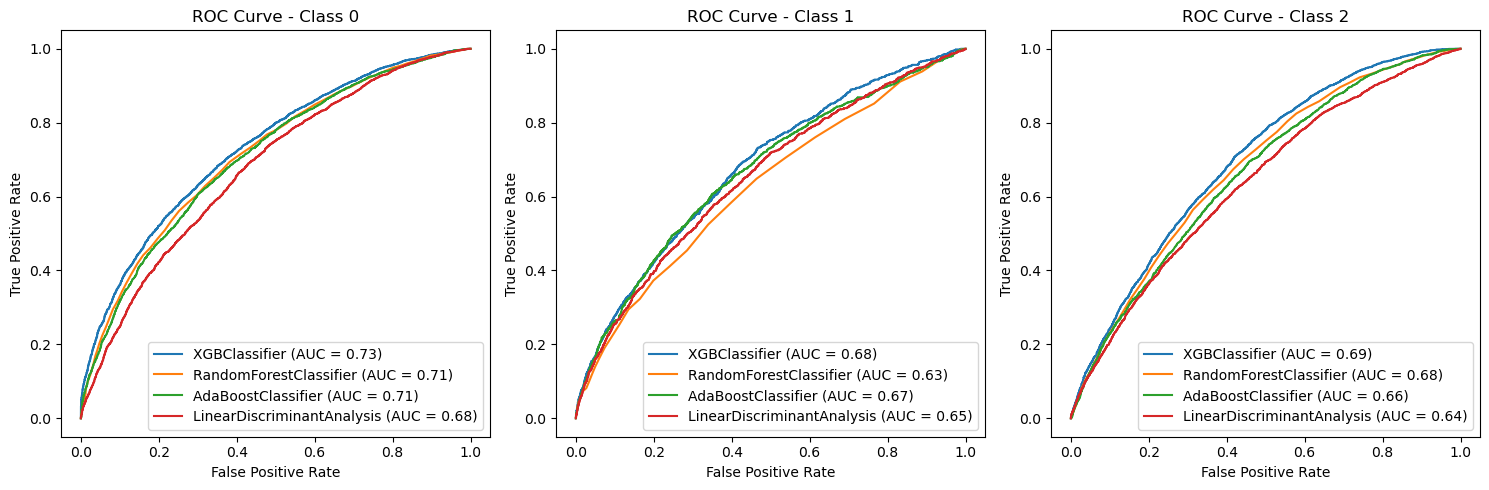

In [131]:
import matplotlib.pyplot as plt

# Plot ROC curves for each class separately
plt.figure(figsize=(15, 5))

# Class 0 ROC curves
plt.subplot(1, 3, 1)
for model_name, values in roc_1.items():
    fpr, tpr, roc_auc = values
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Class 0')
plt.legend()

# Class 1 ROC curves
plt.subplot(1, 3, 2)
for model_name, values in roc_2.items():
    fpr, tpr, roc_auc = values
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Class 1')
plt.legend()

# Class 2 ROC curves
plt.subplot(1, 3, 3)
for model_name, values in roc_3.items():
    fpr, tpr, roc_auc = values
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Class 2')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
cols = ['Model_Name','Accuracy','Precision','Specificity', 'Sensitivity','F1'] 
resDF = pd.DataFrame(columns = cols)
print(resDF.head())
resDF = pd.concat(results(model1,X_train,y_train,X_test,y_test),ignore_index=True)
resDF = resDF.append(results(model2,X_train,y_train,X_test,y_test),ignore_index=True)
resDF = resDF.append(results(model3,X_train,y_train,X_test,y_test),ignore_index=True)
resDF = resDF.append(results(model4,X_train,y_train,X_test,y_test),ignore_index=True)
resDF = resDF.append(results(model5,X_train,y_train,X_test,y_test),ignore_index=True)
resDF = resDF.append(results(model6,X_train,y_train,X_test,y_test),ignore_index=True)
resDF = resDF.append(results(model7,X_train,y_train,X_test,y_test),ignore_index=True)
resDF.to_csv('data/testingClassifiers.csv')

In [97]:
#functi buildensemble(list_models, X, Y): 
 #loop xi through each row of x  
    #for k in 1 to len of list_models
        # model = model1 
        #predk = model.predict(xi, avg=none)
    #row vector of 9 things add Y to the end    
    #return 

In [44]:
#def specificity(ytest,ypred):
#    tn, fp, fn, tp = confusion_matrix(ytest,ypred).ravel()
#    spec = tn/(tn+fp)
#    return spec